In [24]:
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import tifffile as sktif


import numpy as np
import cv2
from functools import partial

from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset
import functools, traceback
import glob
import torch, catalyst

from pathlib import Path
from PIL import Image

import matplotlib.pyplot as plt

import random
%matplotlib inline

is_fp16_used = True
torch.__version__, catalyst.__version__

('1.3.1', '19.09.1')

In [2]:
from catalyst.utils import get_available_gpus

get_available_gpus()

pyarrow not available, switching to pickle. To install pyarrow, run `pip install pyarrow`.
lz4 not available, disabling compression. To install lz4, run `pip install lz4`.


[0]

In [15]:
from apex.fp16_utils import *

In [4]:
from typing import List, Tuple, Callable
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [8]:
def filter_files(files, include=[], exclude=[]):
    for incl in include:
        files = [f for f in files if incl in f.name]
    for excl in exclude:
        files = [f for f in files if excl not in f.name]
    return sorted(files)

def ls(x, recursive=False, include=[], exclude=[]):
    if not recursive:
        out = list(x.iterdir())
    else:
        out = [o for o in x.glob('**/*')]
    out = filter_files(out, include=include, exclude=exclude)
    return out

Path.ls = ls

In [7]:
data_dir = Path("/media/wwymak/Storage/xView2")
mask_dir = data_dir /"mask_full_size"

train_images_crops = data_dir/"train_crops"
train_mask_crops = data_dir/"mask_crops"

In [9]:
train_images_crops.ls()[:5]

[PosixPath('/media/wwymak/Storage/xView2/train_crops/rgb_guatemala-volcano_00000000_pre_disaster._0.png'),
 PosixPath('/media/wwymak/Storage/xView2/train_crops/rgb_guatemala-volcano_00000000_pre_disaster._1.png'),
 PosixPath('/media/wwymak/Storage/xView2/train_crops/rgb_guatemala-volcano_00000000_pre_disaster._3.png'),
 PosixPath('/media/wwymak/Storage/xView2/train_crops/rgb_guatemala-volcano_00000000_pre_disaster._4.png'),
 PosixPath('/media/wwymak/Storage/xView2/train_crops/rgb_guatemala-volcano_00000000_pre_disaster._6.png')]

In [10]:
unique_img_ids = list(set([x.name.replace('mask_', '').split('.')[0] for x in train_mask_crops.ls() ]))
np.random.seed(42)
np.random.shuffle(unique_img_ids)
train_ids = unique_img_ids[:int(0.8 * len(unique_img_ids))]
valid_ids = unique_img_ids[int(0.8 * len(unique_img_ids)):]

In [19]:
def is_valid_func(fname):
    
    img_id = Path(fname).name.replace('rgb_', '').split('.')[0]

    return img_id in valid_ids

def get_mask_fn(fname):
    return train_mask_crops / fname.name.replace("rgb", "mask")

def show_examples(name: str, image: np.ndarray, mask: np.ndarray):
    plt.figure(figsize=(10, 14))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {name}")

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title(f"Mask: {name}")


def show(index: int, images: List[Path], masks: List[Path], transforms=None) -> None:
    image_path = images[index]
    name = image_path.name

    image = np.array(Image.open(image_path))
    mask = np.array(Image.open(masks[index]))

    if transforms is not None:
        temp = transforms(image=image, mask=mask)
        image = temp["image"]
        mask = temp["mask"]

    show_examples(name, image, mask)

def show_random(images: List[Path], masks: List[Path], transforms=None) -> None:
    length = len(images)
    index = random.randint(0, length - 1)
    show(index, images, masks, transforms)

In [21]:
all_images = train_images_crops.ls()
all_masks = [train_mask_crops/x.name.replace('rgb', 'mask') for x in all_images]

all_masks[:2]

[PosixPath('/media/wwymak/Storage/xView2/mask_crops/mask_guatemala-volcano_00000000_pre_disaster._0.png'),
 PosixPath('/media/wwymak/Storage/xView2/mask_crops/mask_guatemala-volcano_00000000_pre_disaster._1.png')]

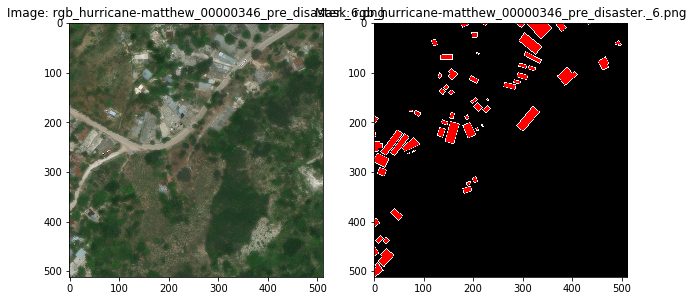

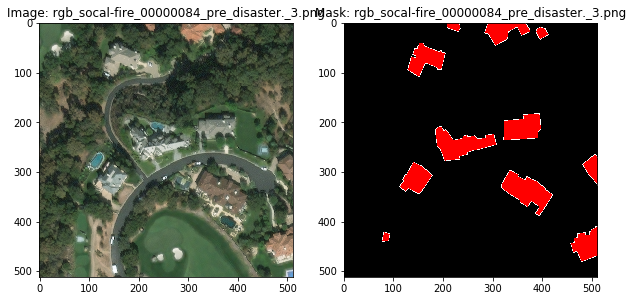

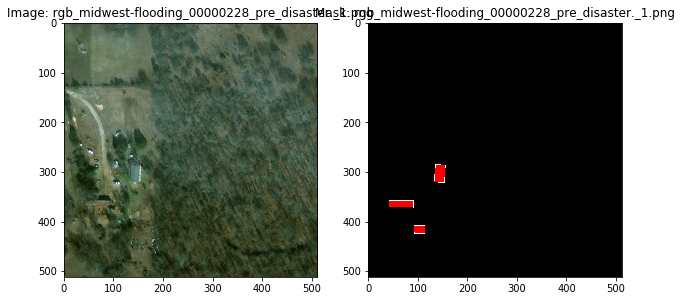

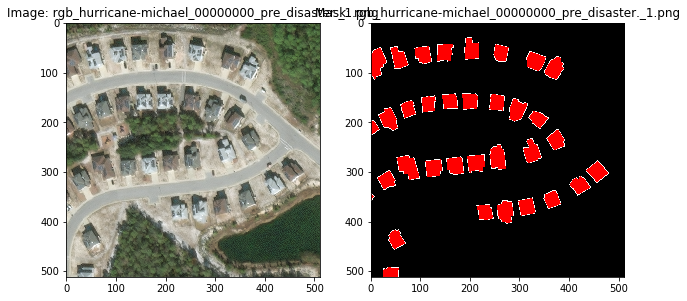

In [26]:
for i in range(4):
    show_random(all_images, all_masks)

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, images:List[Path], masks:List[Path], transforms=None):
        self.images = images
        self.masks = masks
        self.transforms = transforms
        
    def __len__(self):
        return len(self.images)
    
    